# Mining used-car sales

This is a running log of some work on used-car saled. I have no intention to use this information for financial purposes, rather I'd like to ask the question "is there regional variation in used-car prices?". To do this I will use the `BeautifulSoup` package to look at [www.pistonheads.com](www.pistonheads.com), my preferred way to search for used cars.

In [347]:
from BeautifulSoup import BeautifulSoup 
import urllib
import pandas as pd
import seaborn
import numpy as np
import scipy.optimize as so
%matplotlib inline

import seaborn as sns
sns.set_style(rc={'font.family': ['sans-serif'],'axis.labelsize': 25})
sns.set_context("notebook")

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.labelsize'] = 18

After some fiddling I have wrapped up the method to get a page of results (100 at a time) in a function:

In [183]:
def strip_results_from_ad(ad):
    """ Strip out the information from a single advert and add it to the results dictionary"""
    
    desc = ad.find("div", attrs={"class": "listing-headline"}).find("h3").text
    loc = ad.findAll("p", attrs={"class": "location"})[0].text
    price = int(ad.find("div", attrs={"class": "price"}).text.replace(u"&#163;", "").replace(",", ""))   

    specs = ad.find("ul", attrs={"class": "specs"}).findAll("li")
    if len(specs) == 4:
        miles = int(specs[0].text.rstrip(" miles").replace(",", ""))
        fuel = specs[1].text
        bhp = int(specs[2].text.rstrip(" bhp"))
        transmission = specs[3].text
    else:
        fuel = "NA"
        bhp = np.nan
        transmission = "NA"   
        try:
            miles = int(specs[0].text.rstrip(" miles").replace(",", ""))
        except:
            # Except any error...!
            miles = np.nan
            
    return desc, loc, price, miles, fuel, bhp, transmission

def create_url(page=1, M=269, rpp=100):
    base = ("http://www.pistonheads.com/classifieds?Category=used-cars"
            "&M={M}&ResultsPerPage={rpp}&Page={page}")
    return base.format(page=page, rpp=rpp, M=M)

def get_results(*args, **kwargs):
    url = create_url(*args, **kwargs)
    f = urllib.urlopen(url).read()    
    soup = BeautifulSoup(f)
    ads = soup.findAll("div", attrs={"class": "ad-listing"})

    results = {"desc":[], "loc":[], "price":[], "miles":[], "fuel":[], "bhp":[], "transmission":[]}
    for ad in ads:
        try:
            desc, loc, price, miles, fuel, bhp, transmission = strip_results_from_ad(ad)
        except:
            break
    
        results["desc"].append(desc)
        results["loc"].append(loc)
        results["price"].append(price)   
        results["miles"].append(miles)
        results["fuel"].append(fuel)
        results["bhp"].append(bhp)
        results["transmission"].append(transmission)

    return results

### An example

Here we get 100 results from the url with "M" 269. On the pistonheads website this corresponds to a BMW 1 series. I choose this search in particular as there isn't huge variation in the specs, most have a similar engine size and there are few special runs. Let's have a look at the first few results

In [193]:
r = get_results(M=269, rpp=20)
df = pd.DataFrame(r)
df

,bhp,desc,fuel,loc,miles,price,transmission
0,114,BMW 1 Series 116d M Sport 5dr (2014),Diesel,Glasgow,12269,16988,Manual
1,114,BMW 1 Series 116d M Sport 5dr (2014),Diesel,Glasgow,7498,16988,Manual
2,141,BMW 1 Series 118d M Sport 2dr (2010),Diesel,East Kilbride,50293,10988,Manual
3,141,BMW 1 Series 118d Sport 2dr (2011),Diesel,Gateshead,90502,8688,Manual
4,121,2010 59 BMW 1 SERIES 2.0 116I SPORT 3D 121 BHP...,Petrol,Stockport,30000,7870,Manual
5,NaN,2005 54 BMW 1 SERIES 2.0 120D SE DIESEL 5DR (2...,NA,Stockport,118712,4570,NA
6,141,2011 11 BMW 1 SERIES 2.0 118D SPORT 2D 141 BHP...,Diesel,Stockport,94409,12470,Manual
7,174,2010 60 BMW 1 SERIES 2.0 120D M SPORT 2D 175 B...,Diesel,Stockport,47483,11970,Automatic
8,181,BMW 1 Series 120d Sport 5dr (2012),Diesel,Teeside,67174,11488,Manual
9,141,2008 08 BMW 1 SERIES 2.0 118I SE 3D 141 BHP (2...,Petrol,Leeds,22265,7250,Manual


This looks good so far, now from the source website we see there is 2,580 entries so let's pull down a few and see what we can do with the data. The best way to do this is to iterate through the page counts and concatanate the resulting data frames:

In [218]:
dfs = []
for page in xrange(1, 25):
    r = get_results(M=269, rpp=100, page=page)
    dfs.append(pd.DataFrame(r))

In [230]:
df = pd.concat(dfs)
len(df)

1376

Okay so now we have a good number of adverts to look at. 

### Mileage VS Price

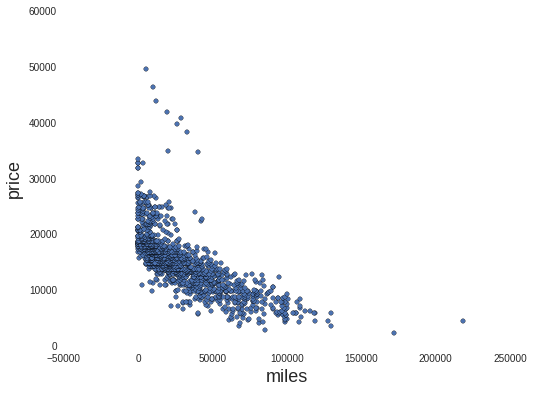

In [348]:
ax = df.sort("price").plot("miles", "price", kind="scatter")

This is kind of messy and I would be interested to know what those low-milage high price outliers indicate

### Outliers

We will use the `pandas` query module (which requires `numexpr` to be installed) to have a look at these outliers.

In [293]:
df.query("miles < 50000 and price > 30000") 

,bhp,desc,fuel,loc,miles,price,transmission
46,315,1 SERIES HATCHBACK M135i M Performance 3dr Ste...,Petrol,Berkshire,3524,32850,Automatic
49,NaN,1 SERIES HATCHBACK M135i 3dr Step Auto (2015),NA,West Midlands,10,33625,NA
10,NaN,BMW 1M **UK`S FINEST BUYERS** (2011),NA,Nottinghamshire,20000,35000,NA
27,335,BMW 1 SERIES 3.0 M 2dr (2011),Petrol,Durham,40000,34990,Manual
89,335,2011/61 BMW 1M COUPE - ORANGE - SAT NAV - 32K ...,Petrol,Deeside,32900,38495,Manual
15,335,BMW 1 Series M (2011),Petrol,Oxfordshire,19500,41995,Manual
85,335,BMW 1M 2...,Petrol,Grampian,29000,41000,Manual
57,335,1 SERIES COUPE M 2dr (2011),Petrol,Nottinghamshire,5434,49850,Manual
67,NaN,BMW 1 SERIES 125d M Sport 5dr Step Auto [Nav] ...,NA,Derbyshire,156,32990,NA
68,322,BMW 1 SERIES M135i 3dr Step Auto (2015),Petrol,Derbyshire,156,32990,Automatic


As we can see these are all the "1M" series, a much faster version. The BHP is 335 which is significantly greater than the average:

In [252]:
df.bhp.mean()

151.81108508977363

### Averaged Price VS Mileage

Let's clean the data by removing all `NaN` (this is typically ill-advised, but this is just for fun) and also get rid of those high-performance cars

In [306]:
df_clean = df[~np.isnan(df.price)]
df_clean = df_clean[~np.isnan(df_clean.miles)]
df_clean = df_clean[df_clean.price < 30000]
df_clean = df_clean.sort("miles")

And now we have a clean collection, we will apply a rolling mean to the price and milage:

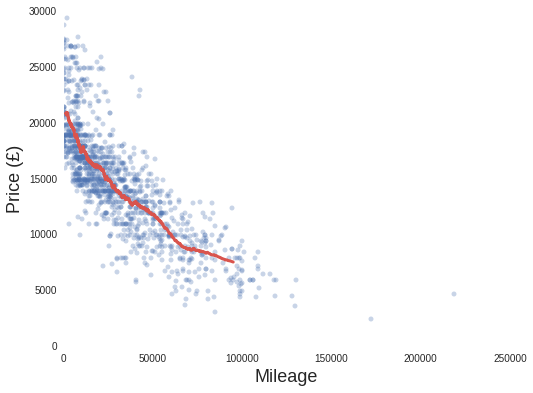

In [349]:
ax = plt.subplot(111)
window = 100

mean_miles = pd.rolling_mean(df_clean.miles, window, center=True)
mean_price = pd.rolling_mean(df_clean.price, window, center=True)

# Drop the nans created in the rolling_window
mean_miles = mean_miles[~np.isnan(mean_miles)]
mean_price = mean_price[~np.isnan(mean_price)]

ax.plot(df_clean.miles, df_clean.price, "o", alpha=0.3, markersize=5)
ax.plot(mean_miles, mean_price, lw=3, color=seaborn.xkcd_rgb["pale red"])
ax.set_xlabel("Mileage")
ax.set_ylabel(u"Price (£)")

plt.show()

### Fitting to the data

We may now imagine coming up with a model for the price. The obvious answer is to begin by stating that the depreciation is proportional to the mileage, therefore:

$$ \frac{dP}{dm} = -k P $$

where $P$ is the price, $m$ is the mileage and $k$ is a constant of proportionality. Solving in the usual way yields:

$$ P(m) = P_{0} e^{-km} $$

Let's try fitting this:

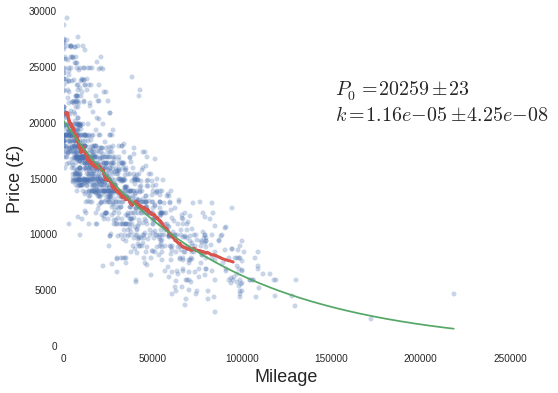

In [354]:
import scipy.optimize as so
ax = plt.subplot(111)

def P(m, P0, k):
    return P0 * np.exp(-k * m)

popt, pcov = so.curve_fit(P, mean_miles, mean_price, p0=[20000, 1e-10])



ax.plot(df_clean.miles, df_clean.price, "o", alpha=0.3, markersize=5)
ax.plot(mean_miles, mean_price, lw=3, color=seaborn.xkcd_rgb["pale red"])

fit_miles = np.linspace(df_clean.miles.min(), df_clean.miles.max(), 1000)
ax.plot(fit_miles, P(fit_miles, *popt), zorder=10)
ax.annotate(xy=(0.6, 0.7), xycoords="figure fraction", 
            s=("$P_0={:5.0f} \pm {:5.0f}$\n$k={:1.2e} \pm {:1.2e}$".format(
               popt[0], np.sqrt(pcov[0, 0]), popt[1], np.sqrt(pcov[1, 1]))), 
            fontsize=20)

ax.set_xlabel("Mileage")
ax.set_ylabel(u"Price (£)")

plt.show()

This model seems fairly able to predict the average used car sale price. The parameter $P_0$ measures the value at 0 miles, of course all used-cars should have at least some mileage to qualify as used, but a surprising number have very low mileage:

In [353]:
len(df.query("miles < 500"))

48

As a result we have predicted the initial price to be $20259 \pm 23$ which isn't all that far off the actual new-car prices $21180-21710$.